In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.transforms import ToTensor, Normalize, Resize, Compose
from torchvision.utils import make_grid

from PIL import Image
import numpy as np
import os
import random
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import tifffile as tiff
import pandas as pd
import pickle
import zipfile

from sklearn.model_selection import train_test_split


In [2]:
zip_dir = '/content/drive/MyDrive/DataSet/satalite_data.zip'
zip_ref = zipfile.ZipFile(zip_dir, 'r')
zip_ref.extractall('/content/sample_data')
zip_ref.close()

In [3]:
main_dir = '/content/sample_data/satalite data/data'
images_dir = os.path.join(main_dir, 'images')
labels_dir = os.path.join(main_dir, 'labels')

In [4]:
for dir, dirname, filename in os.walk(images_dir):
  print(f"Found {len(dirname)} directories and {len(filename)} images in {dir}")

print('-'*100)

for dir, dirname, filename in os.walk(labels_dir):
  print(f"Found {len(dirname)} directories and {len(filename)} images in {dir}")

Found 0 directories and 306 images in /content/sample_data/satalite data/data/images
----------------------------------------------------------------------------------------------------
Found 0 directories and 456 images in /content/sample_data/satalite data/data/labels


In [5]:
allowed_indices = set(str(i) + ".png" for i in range(0, 306))
for filename in os.listdir(labels_dir):
    if filename.endswith('.png'):
        if filename not in allowed_indices:
            os.remove(os.path.join(labels_dir, filename))
            print(f"Deleted: {filename}")
    else:
        # Optionally remove non-jpg images too
        os.remove(os.path.join(labels_dir, filename))
        print(f"Deleted (non-jpg): {filename}")

Deleted: 30_143.png
Deleted: 87_182.png
Deleted: 113_44.png
Deleted: 47_15.png
Deleted: 26_274.png
Deleted: 106_267.png
Deleted: 49_64.png
Deleted: 75_52.png
Deleted: 72_205.png
Deleted: 31_196.png
Deleted: 144_235.png
Deleted: 115_49.png
Deleted: 116_250.png
Deleted: 20_283.png
Deleted: 11_116.png
Deleted: 37_118.png
Deleted: 136_301.png
Deleted: 128_294.png
Deleted: 125_201.png
Deleted: 78_246.png
Deleted: 12_286.png
Deleted: 58_114.png
Deleted: 21_254.png
Deleted: 50_263.png
Deleted: 4_300.png
Deleted: 107_59.png
Deleted: 96_154.png
Deleted: 1_226.png
Deleted: 79_161.png
Deleted: 64_86.png
Deleted: 117_97.png
Deleted: 109_223.png
Deleted: 24_111.png
Deleted: 132_126.png
Deleted: 121_142.png
Deleted: 51_91.png
Deleted: 133_224.png
Deleted: 33_134.png
Deleted: 57_45.png
Deleted: 99_170.png
Deleted: 88_157.png
Deleted: 48_12.png
Deleted: 103_225.png
Deleted: 19_293.png
Deleted: 127_54.png
Deleted: 147_213.png
Deleted: 32_11.png
Deleted: 6_248.png
Deleted: 142_238.png
Deleted: 119_222.p

In [6]:
# Sort filenames numerically (e.g., img_1.tif < img_10.tif)
def sort_key(file):
    return int(''.join(filter(str.isdigit, file)))  # extract numbers from filename
# Get sorted file paths
images = sorted(
    [os.path.join(images_dir, file) for file in os.listdir(images_dir) if file.endswith('.tif')],
    key=sort_key)

masks = sorted(
    [os.path.join(labels_dir, file) for file in os.listdir(labels_dir) if file.endswith(('.png', '.tif'))],
    key=sort_key)

# Combine into DataFrame
data = pd.DataFrame({"image": images, "mask": masks})

# Train/Validation split
train_df, val_df = train_test_split(data, train_size=0.8, random_state=123)


In [7]:
def plot_channels_with_mask(image_path, mask_path, max_channels=12):
    # Load .tif image
    image = tiff.imread(image_path)

    # If shape is (C, H, W), transpose to (H, W, C)
    if image.ndim == 3 and image.shape[0] <= 15:
        image = np.transpose(image, (1, 2, 0))

    # Drop channels 1, 9, and 10 (indices 0, 8, 9)
    drop_indices = [0, 8, 9]
    image = np.delete(image, drop_indices, axis=2)

    # Corresponding channel names (remove dropped ones)
    all_channel_names = [
        "Coastal", "Blue", "Green", "Red",
        "Red Edge 1", "Red Edge 2", "Red Edge 3",
        "NIR", "Narrow NIR", "SWIR 1", "SWIR 2", "Water Vapor"
    ]
    kept_channel_names = [name for i, name in enumerate(all_channel_names) if i not in drop_indices]

    # Load mask (assumed to be grayscale .png)
    mask = np.array(Image.open(mask_path))

    # Plot
    channels = image.shape[2]
    total_plots = min(channels, max_channels) + 1
    cols = 4
    rows = int(np.ceil(total_plots / cols))

    plt.figure(figsize=(15, rows * 3))

    # Plot channels with real names
    for i in range(min(channels, max_channels)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image[:, :, i], cmap='gray')
        plt.title(kept_channel_names[i])  # Use real name
        plt.axis('off')

    # Plot mask
    plt.subplot(rows, cols, total_plots)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

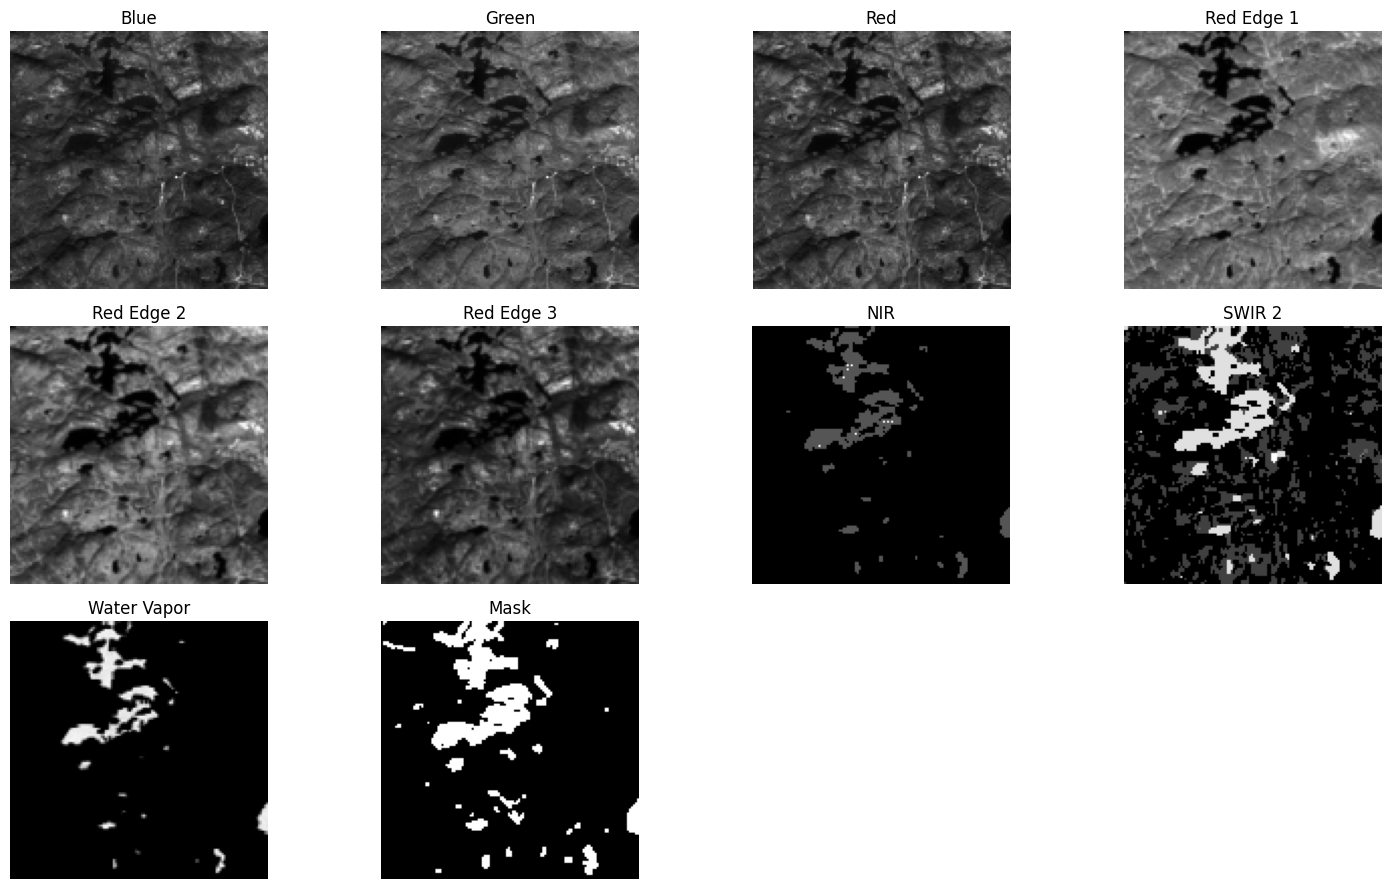

In [8]:
plot_channels_with_mask(images[0],masks[0])

In [9]:
def normalize(band):
    return (band - band.min()) / (band.max() - band.min() + 1e-6)

def compare_rgb_and_mask(image_path, mask_path, rgb_indices=(0, 1, 2), drop_indices=[0, 8, 9]):
    # Load .tif image
    image = tiff.imread(image_path)

    # Transpose to (H, W, C) if needed
    if image.ndim == 3 and image.shape[0] <= 15:
        image = np.transpose(image, (1, 2, 0))

    # Drop specified channels
    image = np.delete(image, drop_indices, axis=2)

    # Extract and normalize RGB channels (R, G, B)
    rgb = np.stack([
        normalize(image[:, :, rgb_indices[2]]),  # R
        normalize(image[:, :, rgb_indices[1]]),  # G
        normalize(image[:, :, rgb_indices[0]])   # B
    ], axis=2)

    # Load mask
    mask = np.array(Image.open(mask_path))
    if mask.ndim == 3:
        mask = mask[:, :, 0]

    # Plot side-by-side comparison
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(rgb)
    plt.title('RGB Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(rgb)
    plt.imshow(mask, cmap='gray', alpha=0.4)
    plt.title('RGB + Mask Overlay')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

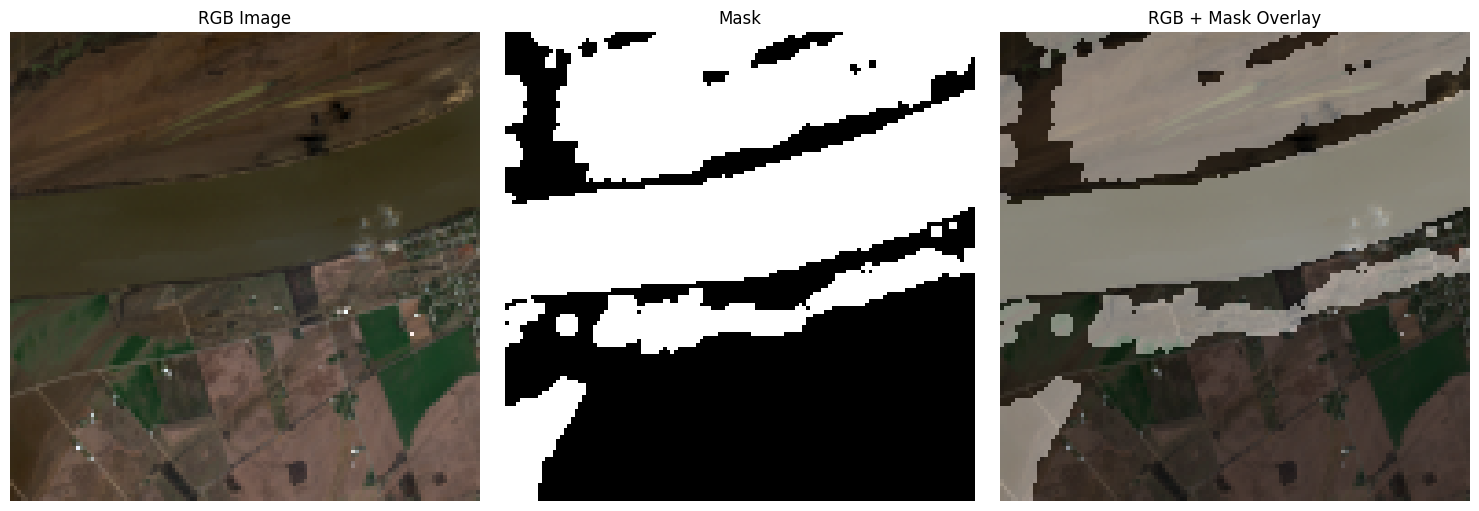

In [10]:
compare_rgb_and_mask(train_df.iloc[0]['image'], train_df.iloc[0]['mask'])

In [11]:
def normalize(band):
    return (band - band.min()) / (band.max() - band.min() + 1e-6)

def compare_ndwi_with_mask(image_path, mask_path, green_index=1, nir_index=6, drop_indices=[0, 8, 9]):
    # Load image and drop unwanted channels
    image = tiff.imread(image_path)
    if image.ndim == 3 and image.shape[0] < 20:
        image = np.transpose(image, (1, 2, 0))
    image = np.delete(image, drop_indices, axis=2)

    # Extract Green and NIR bands
    green = normalize(image[:, :, green_index])
    nir   = normalize(image[:, :, nir_index])

    # Compute NDWI
    ndwi = (green - nir) / (green + nir + 1e-6)

    # Load and process mask
    mask = np.array(Image.open(mask_path))
    if mask.ndim == 3:
        mask = mask[:, :, 0]

    # Plot NDWI and mask
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(ndwi, cmap='Blues')
    plt.title('NDWI')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

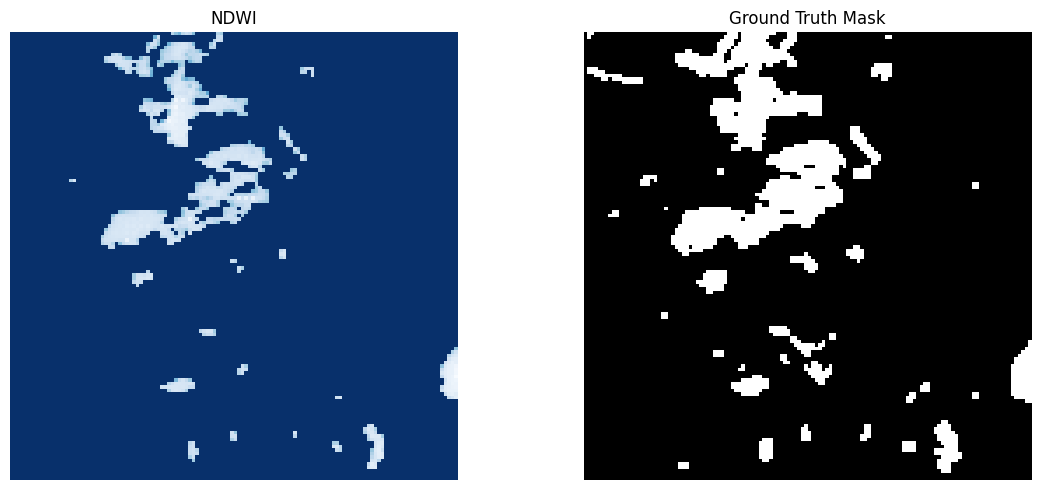

In [12]:
compare_ndwi_with_mask(
    image_path=images[0],
    mask_path=masks[0],
    green_index=1,  # Adjust based on your data
    nir_index=6     # Adjust based on band order *after dropping*
)

In [13]:
import torch
from torch.utils.data import Dataset
import numpy as np
import tifffile as tif
from skimage.io import imread
from skimage.transform import resize
import random

class CustomDataset(Dataset):
    def __init__(self, dataframe, target_size=(128, 128), drop_indices=[0, 8, 9], shuffle=True):
        self.dataframe = dataframe.reset_index(drop=True)
        self.target_size = target_size
        self.drop_indices = drop_indices
        self.shuffle = shuffle

        self.indexes = np.arange(len(self.dataframe))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return len(self.indexes)

    def normalize_image(self, image):
        # Normalize each channel independently
        for c in range(image.shape[2]):
            band = image[:, :, c]
            min_val, max_val = band.min(), band.max()
            if max_val > min_val:
                image[:, :, c] = (band - min_val) / (max_val - min_val + 1e-6)
            else:
                image[:, :, c] = 0.0
        return image

    def __getitem__(self, idx):
        real_idx = self.indexes[idx]
        row = self.dataframe.iloc[real_idx]

        img_path = row["image"]
        mask_path = row["mask"]

        # Load image
        img = tif.imread(img_path).astype(np.float32)

        # Transpose from (C, H, W) → (H, W, C) if needed
        if img.ndim == 3 and img.shape[0] <= 15:
            img = np.transpose(img, (1, 2, 0))

        # Drop specified channels
        img = np.delete(img, self.drop_indices, axis=2)

        # Resize image
        img = resize(img, self.target_size, anti_aliasing=True, preserve_range=True)

        # Normalize image
        img = self.normalize_image(img)

        # Load and resize mask
        mask = imread(mask_path, as_gray=True).astype(np.float32)
        mask = resize(mask, self.target_size, anti_aliasing=True, preserve_range=True)

        # Final shape: image (C, H, W), mask (1, H, W)
        img = np.transpose(img, (2, 0, 1))  # HWC → CHW
        mask = mask[None, :, :]             # HW → 1HW

        # Convert to tensors
        img_tensor = torch.tensor(img, dtype=torch.float32)
        mask_tensor = torch.tensor(mask, dtype=torch.float32)

        return img_tensor, mask_tensor

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [14]:
from torch.utils.data import DataLoader

# Example usage:
train_dataset = CustomDataset(train_df, target_size=(128, 128), drop_indices=[0, 8, 9], shuffle=True)
val_dataset = CustomDataset(val_df, target_size=(128, 128), drop_indices=[0, 8, 9], shuffle=False)

train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True)  # shuffle at loader level
val_loader = DataLoader(val_dataset, batch_size=12, shuffle=False)


In [15]:
pip install segmentation-models-pytorch


In [16]:
!pip install pytorch_lightning


In [17]:
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import transforms
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor


In [18]:
!pip install torchmetrics


In [28]:

dice_loss = smp.losses.DiceLoss(mode='binary')
focal_loss = smp.losses.FocalLoss(mode='binary')

def loss_fn(y_pred, y_true):
    return dice_loss(y_pred, y_true) + focal_loss(y_pred, y_true)

from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score

# Define metrics and move to device
metrics = {
    'iou': BinaryJaccardIndex(threshold=0.5).to(device),
    'fscore': BinaryF1Score(threshold=0.5).to(device),
}




In [41]:
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.optim as optim

LR = 1e-4
BATCH_SIZE = 16
INPUT_SHAPE = (9, 128, 128)  # PyTorch uses (C, H, W)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model setup: Use DeepLabV3+ instead of Unet
model = smp.DeepLabV3Plus(
    encoder_name='se_resnext50_32x4d',  # Can change to 'resnet34', 'efficientnet-b0', etc.
    encoder_weights=None,              # No pre-trained weights for 9 channels
    in_channels=9,                     # 9-channel input
    classes=1,                         # Binary segmentation (1 class)
    activation=None                    # Apply sigmoid during evaluation
).to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)


In [42]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Learning rate scheduler (ReduceLROnPlateau)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=5, verbose=True
)


In [52]:
from tqdm import tqdm
import torch
import numpy as np
import copy

# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model_wts = copy.deepcopy(model.state_dict())
best_iou = 0.0
patience = 15
patience_counter = 0

history = {
    "train_loss": [],
    "val_loss": [],
    "train_f1": [],
    "val_f1": [],
    "train_iou": [],
    "val_iou": [],
}

# --- Learning Rate Scheduler ---
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)

# --- Training Loop ---
num_epochs = 50
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Training
    model.train()
    train_loss = []
    train_iou_scores = []
    train_f_scores = []

    for images, masks in tqdm(train_loader):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

        with torch.no_grad():
            preds = torch.sigmoid(outputs)
            iou = metrics["iou"](preds, masks).cpu().numpy()
            fscore = metrics["fscore"](preds, masks).cpu().numpy()
            train_iou_scores.append(iou)
            train_f_scores.append(fscore)

    avg_train_loss = np.mean(train_loss)
    avg_train_iou = np.mean(train_iou_scores)
    avg_train_fscore = np.mean(train_f_scores)

    # Validation
    model.eval()
    val_loss = []
    val_iou_scores = []
    val_f_scores = []

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, masks)
            val_loss.append(loss.item())

            preds = torch.sigmoid(outputs)
            iou = metrics["iou"](preds, masks).cpu().numpy()
            fscore = metrics["fscore"](preds, masks).cpu().numpy()
            val_iou_scores.append(iou)
            val_f_scores.append(fscore)

    avg_val_loss = np.mean(val_loss)
    avg_val_iou = np.mean(val_iou_scores)
    avg_val_fscore = np.mean(val_f_scores)

    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
          f"Train IOU: {avg_train_iou:.4f} | Val IOU: {avg_val_iou:.4f} | "
          f"Train F1: {avg_train_fscore:.4f} | Val F1: {avg_val_fscore:.4f}")

    # Scheduler step
    scheduler.step(avg_val_iou)

    # Save to history
    history["train_loss"].append(avg_train_loss)
    history["val_loss"].append(avg_val_loss)
    history["train_f1"].append(avg_train_fscore)
    history["val_f1"].append(avg_val_fscore)
    history["train_iou"].append(avg_train_iou)
    history["val_iou"].append(avg_val_iou)

    # Early stopping
    if avg_val_iou > best_iou:
        best_iou = avg_val_iou
        best_model_wts = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"Patience Counter: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# --- Load Best Model ---
model.load_state_dict(best_model_wts)



Epoch 1/50


100%|██████████| 21/21 [00:03<00:00,  5.49it/s]


Train Loss: 0.1910 | Val Loss: 0.2226 | Train IOU: 0.8309 | Val IOU: 0.6395 | Train F1: 0.9016 | Val F1: 0.7226

Epoch 2/50


100%|██████████| 21/21 [00:04<00:00,  5.09it/s]


Train Loss: 0.1853 | Val Loss: 0.2264 | Train IOU: 0.8454 | Val IOU: 0.6382 | Train F1: 0.9152 | Val F1: 0.7216
Patience Counter: 1/15

Epoch 3/50


100%|██████████| 21/21 [00:03<00:00,  5.66it/s]


Train Loss: 0.1666 | Val Loss: 0.2246 | Train IOU: 0.8534 | Val IOU: 0.6386 | Train F1: 0.9201 | Val F1: 0.7220
Patience Counter: 2/15

Epoch 4/50


100%|██████████| 21/21 [00:03<00:00,  5.62it/s]


Train Loss: 0.1998 | Val Loss: 0.2261 | Train IOU: 0.8230 | Val IOU: 0.6384 | Train F1: 0.8987 | Val F1: 0.7218
Patience Counter: 3/15

Epoch 5/50


100%|██████████| 21/21 [00:04<00:00,  5.17it/s]


Train Loss: 0.1687 | Val Loss: 0.2261 | Train IOU: 0.8511 | Val IOU: 0.6369 | Train F1: 0.9189 | Val F1: 0.7208
Patience Counter: 4/15

Epoch 6/50


100%|██████████| 21/21 [00:03<00:00,  5.62it/s]


Train Loss: 0.1674 | Val Loss: 0.2261 | Train IOU: 0.8554 | Val IOU: 0.6378 | Train F1: 0.9212 | Val F1: 0.7214
Patience Counter: 5/15

Epoch 7/50


100%|██████████| 21/21 [00:03<00:00,  5.62it/s]


Train Loss: 0.1627 | Val Loss: 0.2272 | Train IOU: 0.8557 | Val IOU: 0.6373 | Train F1: 0.9214 | Val F1: 0.7211
Patience Counter: 6/15

Epoch 8/50


100%|██████████| 21/21 [00:04<00:00,  5.13it/s]


Train Loss: 0.1732 | Val Loss: 0.2296 | Train IOU: 0.8532 | Val IOU: 0.6366 | Train F1: 0.9203 | Val F1: 0.7206
Patience Counter: 7/15

Epoch 9/50


100%|██████████| 21/21 [00:03<00:00,  5.64it/s]


Train Loss: 0.1719 | Val Loss: 0.2268 | Train IOU: 0.8487 | Val IOU: 0.6387 | Train F1: 0.9171 | Val F1: 0.7220
Patience Counter: 8/15

Epoch 10/50


100%|██████████| 21/21 [00:03<00:00,  5.65it/s]


Train Loss: 0.1683 | Val Loss: 0.2261 | Train IOU: 0.8517 | Val IOU: 0.6386 | Train F1: 0.9192 | Val F1: 0.7219
Patience Counter: 9/15

Epoch 11/50


100%|██████████| 21/21 [00:04<00:00,  5.19it/s]


Train Loss: 0.1649 | Val Loss: 0.2264 | Train IOU: 0.8552 | Val IOU: 0.6387 | Train F1: 0.9214 | Val F1: 0.7220
Patience Counter: 10/15

Epoch 12/50


100%|██████████| 21/21 [00:03<00:00,  5.77it/s]


Train Loss: 0.1611 | Val Loss: 0.2255 | Train IOU: 0.8584 | Val IOU: 0.6391 | Train F1: 0.9231 | Val F1: 0.7223
Patience Counter: 11/15

Epoch 13/50


100%|██████████| 21/21 [00:03<00:00,  5.74it/s]


Train Loss: 0.1591 | Val Loss: 0.2246 | Train IOU: 0.8603 | Val IOU: 0.6389 | Train F1: 0.9243 | Val F1: 0.7221
Patience Counter: 12/15

Epoch 14/50


100%|██████████| 21/21 [00:03<00:00,  5.34it/s]


Train Loss: 0.1665 | Val Loss: 0.2270 | Train IOU: 0.8519 | Val IOU: 0.6373 | Train F1: 0.9192 | Val F1: 0.7211
Patience Counter: 13/15

Epoch 15/50


100%|██████████| 21/21 [00:03<00:00,  5.66it/s]


Train Loss: 0.1693 | Val Loss: 0.2257 | Train IOU: 0.8507 | Val IOU: 0.6380 | Train F1: 0.9179 | Val F1: 0.7215
Patience Counter: 14/15

Epoch 16/50


100%|██████████| 21/21 [00:03<00:00,  5.77it/s]


Train Loss: 0.1597 | Val Loss: 0.2237 | Train IOU: 0.8579 | Val IOU: 0.6397 | Train F1: 0.9231 | Val F1: 0.7226

Epoch 17/50


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.1769 | Val Loss: 0.2243 | Train IOU: 0.8404 | Val IOU: 0.6386 | Train F1: 0.9115 | Val F1: 0.7220
Patience Counter: 1/15

Epoch 18/50


100%|██████████| 21/21 [00:03<00:00,  5.53it/s]


Train Loss: 0.1592 | Val Loss: 0.2252 | Train IOU: 0.8604 | Val IOU: 0.6377 | Train F1: 0.9243 | Val F1: 0.7213
Patience Counter: 2/15

Epoch 19/50


100%|██████████| 21/21 [00:03<00:00,  5.71it/s]


Train Loss: 0.1628 | Val Loss: 0.2261 | Train IOU: 0.8539 | Val IOU: 0.6377 | Train F1: 0.9206 | Val F1: 0.7213
Patience Counter: 3/15

Epoch 20/50


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.1741 | Val Loss: 0.2256 | Train IOU: 0.8482 | Val IOU: 0.6379 | Train F1: 0.9171 | Val F1: 0.7215
Patience Counter: 4/15

Epoch 21/50


100%|██████████| 21/21 [00:04<00:00,  4.78it/s]


Train Loss: 0.1713 | Val Loss: 0.2264 | Train IOU: 0.8493 | Val IOU: 0.6373 | Train F1: 0.9177 | Val F1: 0.7211
Patience Counter: 5/15

Epoch 22/50


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.1695 | Val Loss: 0.2273 | Train IOU: 0.8522 | Val IOU: 0.6372 | Train F1: 0.9198 | Val F1: 0.7210
Patience Counter: 6/15

Epoch 23/50


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.1594 | Val Loss: 0.2238 | Train IOU: 0.8575 | Val IOU: 0.6402 | Train F1: 0.9227 | Val F1: 0.7230

Epoch 24/50


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.1615 | Val Loss: 0.2236 | Train IOU: 0.8563 | Val IOU: 0.6394 | Train F1: 0.9220 | Val F1: 0.7225
Patience Counter: 1/15

Epoch 25/50


100%|██████████| 21/21 [00:03<00:00,  5.68it/s]


Train Loss: 0.1924 | Val Loss: 0.2251 | Train IOU: 0.8298 | Val IOU: 0.6392 | Train F1: 0.8987 | Val F1: 0.7223
Patience Counter: 2/15

Epoch 26/50


100%|██████████| 21/21 [00:03<00:00,  5.50it/s]


Train Loss: 0.1699 | Val Loss: 0.2237 | Train IOU: 0.8482 | Val IOU: 0.6393 | Train F1: 0.9169 | Val F1: 0.7224
Patience Counter: 3/15

Epoch 27/50


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.1685 | Val Loss: 0.2274 | Train IOU: 0.8520 | Val IOU: 0.6368 | Train F1: 0.9194 | Val F1: 0.7207
Patience Counter: 4/15

Epoch 28/50


100%|██████████| 21/21 [00:03<00:00,  5.67it/s]


Train Loss: 0.1627 | Val Loss: 0.2257 | Train IOU: 0.8540 | Val IOU: 0.6383 | Train F1: 0.9204 | Val F1: 0.7217
Patience Counter: 5/15

Epoch 29/50


100%|██████████| 21/21 [00:03<00:00,  5.65it/s]


Train Loss: 0.1711 | Val Loss: 0.2249 | Train IOU: 0.8486 | Val IOU: 0.6394 | Train F1: 0.9173 | Val F1: 0.7225
Patience Counter: 6/15

Epoch 30/50


100%|██████████| 21/21 [00:03<00:00,  5.31it/s]


Train Loss: 0.1756 | Val Loss: 0.2281 | Train IOU: 0.8452 | Val IOU: 0.6357 | Train F1: 0.9146 | Val F1: 0.7200
Patience Counter: 7/15

Epoch 31/50


100%|██████████| 21/21 [00:03<00:00,  5.64it/s]


Train Loss: 0.1651 | Val Loss: 0.2280 | Train IOU: 0.8543 | Val IOU: 0.6369 | Train F1: 0.9208 | Val F1: 0.7207
Patience Counter: 8/15

Epoch 32/50


100%|██████████| 21/21 [00:03<00:00,  5.61it/s]


Train Loss: 0.1649 | Val Loss: 0.2277 | Train IOU: 0.8517 | Val IOU: 0.6368 | Train F1: 0.9192 | Val F1: 0.7207
Patience Counter: 9/15

Epoch 33/50


100%|██████████| 21/21 [00:04<00:00,  5.25it/s]


Train Loss: 0.1872 | Val Loss: 0.2284 | Train IOU: 0.8424 | Val IOU: 0.6371 | Train F1: 0.9133 | Val F1: 0.7209
Patience Counter: 10/15

Epoch 34/50


100%|██████████| 21/21 [00:03<00:00,  5.69it/s]


Train Loss: 0.1602 | Val Loss: 0.2291 | Train IOU: 0.8574 | Val IOU: 0.6369 | Train F1: 0.9228 | Val F1: 0.7208
Patience Counter: 11/15

Epoch 35/50


100%|██████████| 21/21 [00:03<00:00,  5.68it/s]


Train Loss: 0.1609 | Val Loss: 0.2274 | Train IOU: 0.8577 | Val IOU: 0.6366 | Train F1: 0.9229 | Val F1: 0.7206
Patience Counter: 12/15

Epoch 36/50


100%|██████████| 21/21 [00:04<00:00,  5.23it/s]


Train Loss: 0.1762 | Val Loss: 0.2253 | Train IOU: 0.8492 | Val IOU: 0.6377 | Train F1: 0.9173 | Val F1: 0.7213
Patience Counter: 13/15

Epoch 37/50


100%|██████████| 21/21 [00:03<00:00,  5.70it/s]


Train Loss: 0.1640 | Val Loss: 0.2245 | Train IOU: 0.8557 | Val IOU: 0.6393 | Train F1: 0.9214 | Val F1: 0.7224
Patience Counter: 14/15

Epoch 38/50


100%|██████████| 21/21 [00:03<00:00,  5.72it/s]


Train Loss: 0.2148 | Val Loss: 0.2221 | Train IOU: 0.8102 | Val IOU: 0.6405 | Train F1: 0.8770 | Val F1: 0.7232

Epoch 39/50


100%|██████████| 21/21 [00:04<00:00,  5.19it/s]


Train Loss: 0.1737 | Val Loss: 0.2284 | Train IOU: 0.8498 | Val IOU: 0.6375 | Train F1: 0.9182 | Val F1: 0.7212
Patience Counter: 1/15

Epoch 40/50


100%|██████████| 21/21 [00:03<00:00,  5.72it/s]


Train Loss: 0.1770 | Val Loss: 0.2289 | Train IOU: 0.8509 | Val IOU: 0.6378 | Train F1: 0.9186 | Val F1: 0.7214
Patience Counter: 2/15

Epoch 41/50


100%|██████████| 21/21 [00:03<00:00,  5.69it/s]


Train Loss: 0.1759 | Val Loss: 0.2291 | Train IOU: 0.8467 | Val IOU: 0.6367 | Train F1: 0.9155 | Val F1: 0.7206
Patience Counter: 3/15

Epoch 42/50


100%|██████████| 21/21 [00:04<00:00,  5.23it/s]


Train Loss: 0.1614 | Val Loss: 0.2290 | Train IOU: 0.8570 | Val IOU: 0.6374 | Train F1: 0.9224 | Val F1: 0.7211
Patience Counter: 4/15

Epoch 43/50


100%|██████████| 21/21 [00:03<00:00,  5.72it/s]


Train Loss: 0.1615 | Val Loss: 0.2310 | Train IOU: 0.8572 | Val IOU: 0.6359 | Train F1: 0.9223 | Val F1: 0.7201
Patience Counter: 5/15

Epoch 44/50


100%|██████████| 21/21 [00:03<00:00,  5.69it/s]


Train Loss: 0.1579 | Val Loss: 0.2268 | Train IOU: 0.8603 | Val IOU: 0.6377 | Train F1: 0.9244 | Val F1: 0.7214
Patience Counter: 6/15

Epoch 45/50


100%|██████████| 21/21 [00:03<00:00,  5.27it/s]


Train Loss: 0.1708 | Val Loss: 0.2295 | Train IOU: 0.8528 | Val IOU: 0.6366 | Train F1: 0.9198 | Val F1: 0.7206
Patience Counter: 7/15

Epoch 46/50


100%|██████████| 21/21 [00:03<00:00,  5.73it/s]


Train Loss: 0.1741 | Val Loss: 0.2299 | Train IOU: 0.8468 | Val IOU: 0.6367 | Train F1: 0.9159 | Val F1: 0.7206
Patience Counter: 8/15

Epoch 47/50


100%|██████████| 21/21 [00:03<00:00,  5.73it/s]


Train Loss: 0.1684 | Val Loss: 0.2251 | Train IOU: 0.8513 | Val IOU: 0.6389 | Train F1: 0.9189 | Val F1: 0.7221
Patience Counter: 9/15

Epoch 48/50


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.1831 | Val Loss: 0.2239 | Train IOU: 0.8402 | Val IOU: 0.6397 | Train F1: 0.9080 | Val F1: 0.7227
Patience Counter: 10/15

Epoch 49/50


100%|██████████| 21/21 [00:03<00:00,  5.56it/s]


Train Loss: 0.1759 | Val Loss: 0.2300 | Train IOU: 0.8454 | Val IOU: 0.6373 | Train F1: 0.9151 | Val F1: 0.7211
Patience Counter: 11/15

Epoch 50/50


100%|██████████| 21/21 [00:03<00:00,  5.69it/s]


Train Loss: 0.1669 | Val Loss: 0.2244 | Train IOU: 0.8509 | Val IOU: 0.6392 | Train F1: 0.9185 | Val F1: 0.7223
Patience Counter: 12/15


<All keys matched successfully>

In [53]:
import torch
from tqdm import tqdm
import numpy as np

# Set model to evaluation mode
# Set model to evaluation mode
model.eval()
val_loss = []
iou_scores = []
f_scores = []

# Reset metric states (optional but good practice)
for metric in metrics.values():
    metric.reset()

with torch.no_grad():
    for step, (images, masks) in enumerate(tqdm(val_loader)):
        if step >= 5:
            break  # simulate steps=5

        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = loss_fn(outputs, masks)
        val_loss.append(loss.item())

        preds = torch.sigmoid(outputs)

        # Update metrics
        iou = metrics["iou"](preds, masks).cpu().item()
        f1 = metrics["fscore"](preds, masks).cpu().item()

        iou_scores.append(iou)
        f_scores.append(f1)

# Averages
loss_value = np.mean(val_loss)
iou_value = np.mean(iou_scores)
f1_value = np.mean(f_scores)

print(f'Validation Loss: {loss_value:.4f}')
print(f'Validation F1-Score: {f1_value:.4f}')
print(f'Validation IoU: {iou_value:.4f}')


 83%|████████▎ | 5/6 [00:00<00:00,  9.19it/s]

Validation Loss: 0.2665
Validation F1-Score: 0.8678
Validation IoU: 0.7686


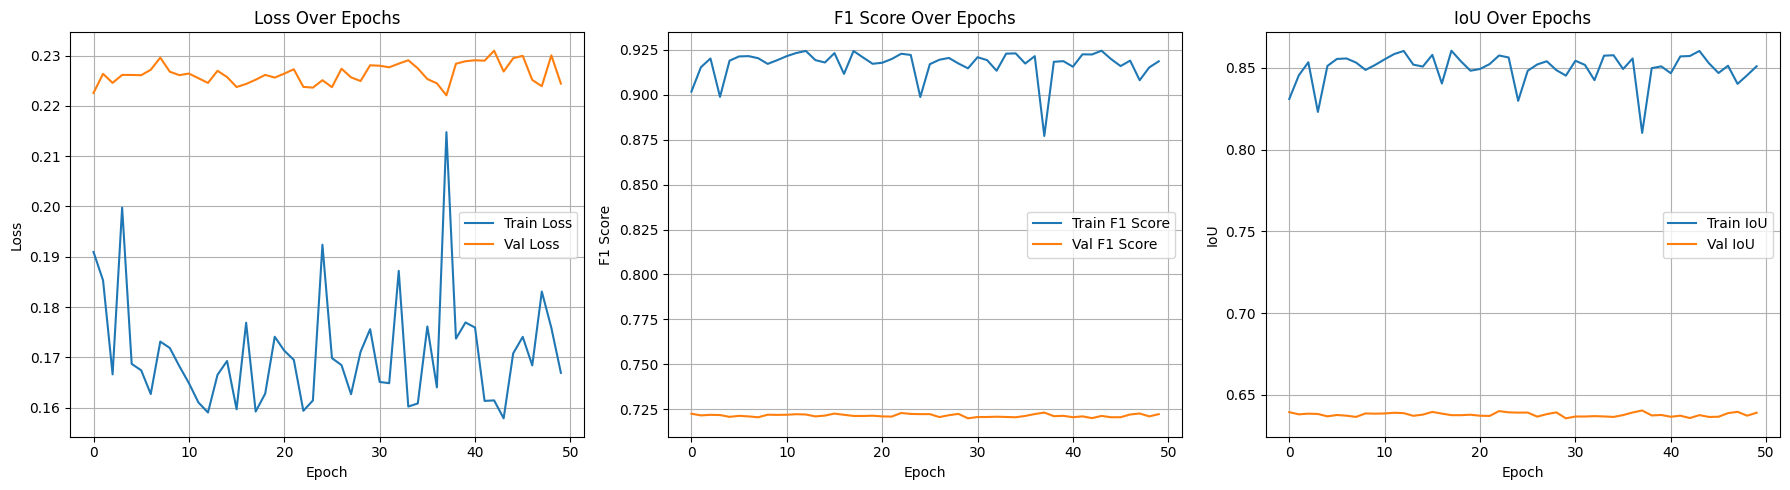

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 5))

# Loss
plt.subplot(1, 3, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# F1 Score
plt.subplot(1, 3, 2)
plt.plot(history["train_f1"], label="Train F1 Score")
plt.plot(history["val_f1"], label="Val F1 Score")
plt.title("F1 Score Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)

# IoU
plt.subplot(1, 3, 3)
plt.plot(history["train_iou"], label="Train IoU")
plt.plot(history["val_iou"], label="Val IoU")
plt.title("IoU Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


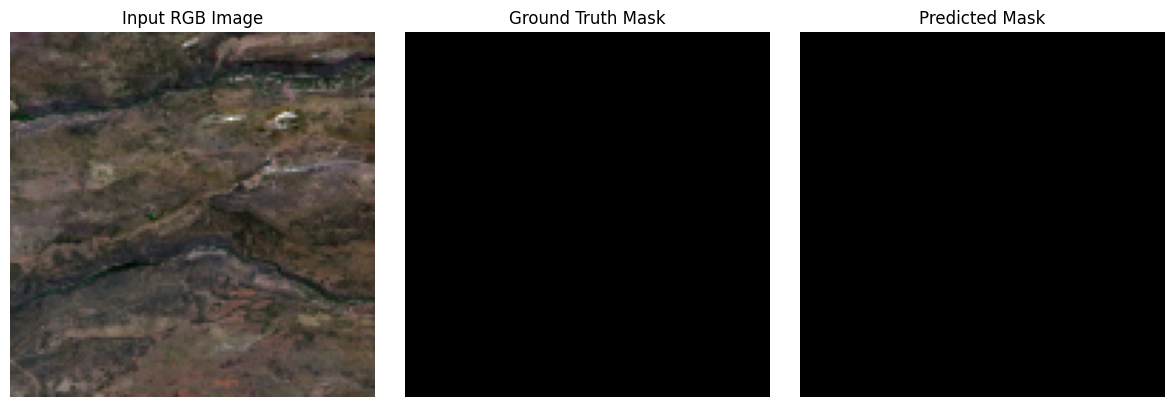

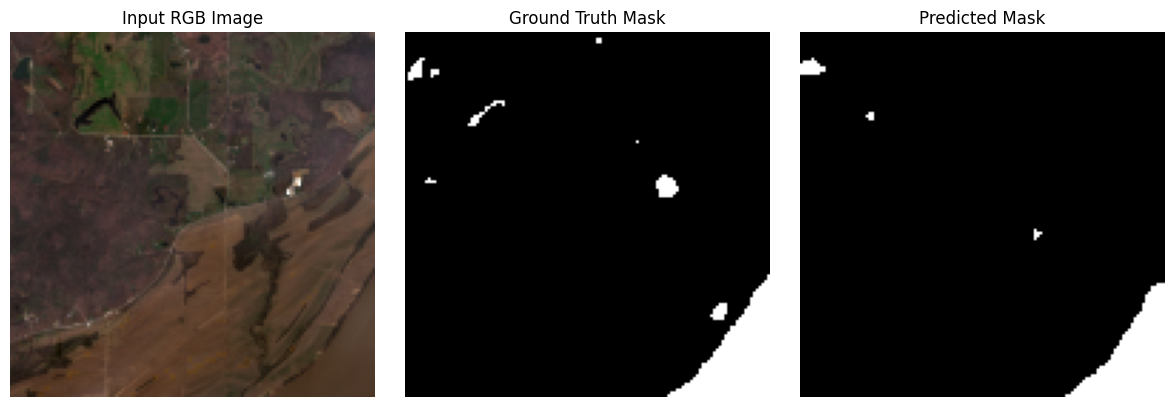

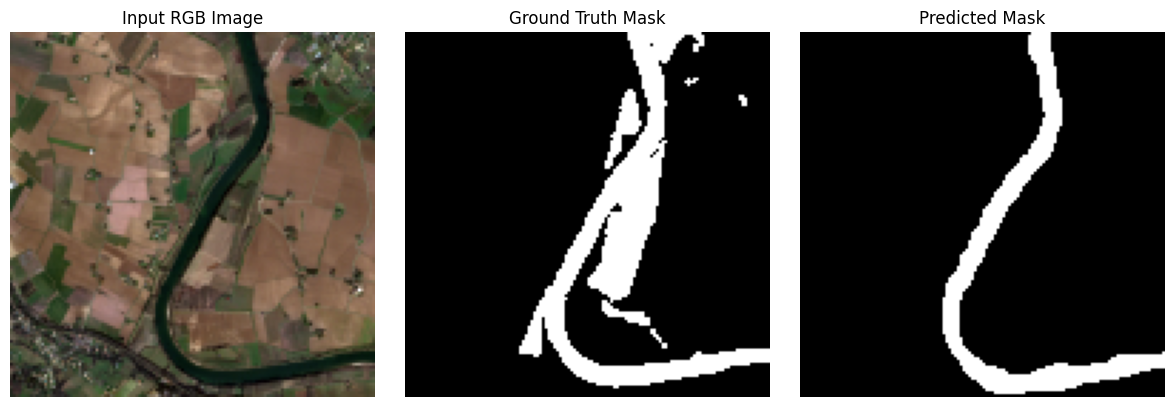

In [55]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Get a batch from validation loader
model.eval()
with torch.no_grad():
    images, true_masks = next(iter(val_loader))
    images = images.to(device)
    true_masks = true_masks.to(device)

    # Predict masks
    outputs = model(images)
    pred_masks = torch.sigmoid(outputs)
    pred_masks = (pred_masks > 0.5).float()

# Move tensors to CPU and convert to numpy
images = images.cpu().numpy()
true_masks = true_masks.cpu().numpy()
pred_masks = pred_masks.cpu().numpy()

# Show a few comparisons
num_samples = 3
for i in range(num_samples):
    plt.figure(figsize=(12, 4))

    # RGB visualization from 9-channel input
    rgb = images[i+5][[2, 1, 0], :, :]  # Reorder from BGR → RGB
    rgb = np.transpose(rgb, (1, 2, 0))  # [C, H, W] → [H, W, C]
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())  # Normalize for display


    # Input image
    plt.subplot(1, 3, 1)
    plt.imshow(rgb)
    plt.title("Input RGB Image")
    plt.axis("off")

    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(true_masks[i+5].squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(pred_masks[i+5].squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [56]:
torch.save(model.state_dict(), "best_model.pth")


In [57]:
%%writefile app.py
from flask import Flask, request, jsonify
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
import io
import segmentation_models_pytorch as smp

app = Flask(__name__)

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = smp.Unet(
    encoder_name='se_resnext50_32x4d',
    encoder_weights=None,
    in_channels=9,
    classes=1,
    activation=None
)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()
model.to(device)

def preprocess_image(image_bytes):
    image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
    image = image.resize((128, 128))
    np_image = np.array(image).astype(np.float32) / 255.0
    np_image = np.transpose(np_image, (2, 0, 1))  # HWC → CHW
    # For example purposes, we duplicate RGB → 9 channels
    np_image = np.tile(np_image, (3, 1, 1))[:9, :, :]
    return torch.tensor(np_image).unsqueeze(0)

@app.route('/predict', methods=['POST'])
def predict():
    if 'file' not in request.files:
        return jsonify({'error': 'No file uploaded'}), 400
    file = request.files['file']
    input_tensor = preprocess_image(file.read()).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.sigmoid(output)
        pred = (pred > 0.5).float().cpu().numpy()

    return jsonify({'prediction_shape': pred.shape})

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)



Writing app.py


In [58]:
!pip install flask pyngrok


In [69]:
import subprocess

# Run Flask app in background
flask_process = subprocess.Popen(["python3", "app.py"])


In [71]:
from pyngrok import ngrok

# Set your Ngrok authtoken
ngrok.set_auth_token("30e60UOsdLDLxD2Fy2KBLDNqwU2_5sYAVgygWdc52rmYANh5A")

# Kill any existing tunnels
ngrok.kill()

# ✅ Use 'addr' instead of 'port'
public_url = ngrok.connect(addr="5000")  # or addr="http://localhost:5000"
print("Public URL:", public_url)



Public URL: NgrokTunnel: "https://bd528cb4bd2e.ngrok-free.app" -> "http://localhost:5000"


In [74]:
from google.colab import files
uploaded = files.upload()


Saving 7.tif to 7.tif


In [77]:
import requests

filename = list(uploaded.keys())[0]
url = public_url.public_url + "/predict"  # ✅ Extract just the URL string
files = {"file": open(filename, "rb")}

response = requests.post(url, files=files)
print("✅ Prediction Response:", response.json())


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [76]:
url = public_url.public_url + "/predict"
